In [98]:
"""
Authors      : Aditya Jain and Safwan Jamal
Date started : November 8, 2022
About        : Convex Optimization project; code for solving convex opt problem
"""

import os
import glob
import numpy as np
import pickle
import cvxpy as cp
import seaborn as sns

#### Reading dissimilarity data data

In [99]:
filename = open('./dissimilarity_data_cifar/airplane_dissimilarity_matrix_100x100.pickle', 'rb')
D        = pickle.load(filename)
n        = len(D)

#### Optimization program

In [100]:
# print(D)
lambda_max = 0
for i in range(n):
    for j in range(i+1, n):
        lambda_cur = (np.sqrt(n)/2 ) * ((np.linalg.norm(D[i, :] - D[j, :])**2)/np.sum((D[i, :] - D[j, :])))  # l2-norm
        lambda_cur = np.linalg.norm(D[i, :] - D[j, :], ord=1)/2  #l-infinity norm
#           print(f'Current lambda is {lambda_cur}')

        if lambda_cur>lambda_max:
            lambda_max = lambda_cur

print(f'Maximum lambda is {lambda_max}')

Maximum lambda is 11.887038074488535


In [104]:
# variable definitions
Z        = cp.Variable((n, n), symmetric=True)
lambda_t = 12


# objective function
cost_encoding = cp.trace(D.T@Z)        # cost of encoding all data points using representatives
cost_no_repr  = 0                      # cost associated with no. of representatives
for i in range(n):
#     cost_no_repr += cp.norm2(Z[i, :])    # l2 norm
    cost_no_repr += cp.max(Z[i, :])  # l-infinity norm
cost_no_repr = lambda_t*cost_no_repr

# objective function
objective    = cp.Minimize(cost_encoding + cost_no_repr)

# constraints
# probab. should be >=0
# probabilities should sum to one for every column
constraints = [Z>=0, np.ones((1,n))@Z == np.ones((1,n))]

# optimization program
prob = cp.Problem(objective, constraints)
prob.solve()

79.00895214029268

<AxesSubplot: >

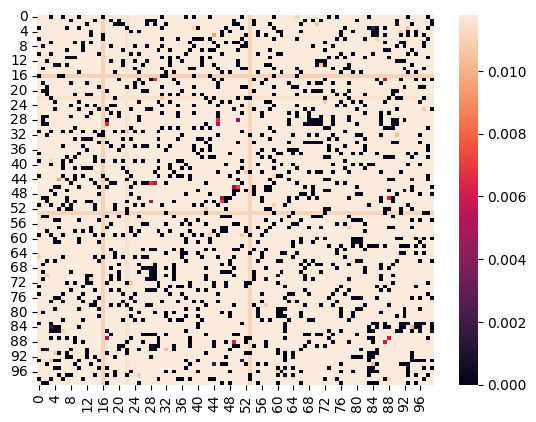

In [105]:
sns.heatmap(Z.value)

In [103]:
Z.value

array([[ 1.26863349e-02,  1.26863349e-02,  1.26863349e-02, ...,
         1.26863349e-02, -9.93488359e-14,  1.26863349e-02],
       [ 1.26863349e-02,  1.26863349e-02,  1.26863349e-02, ...,
         1.26863349e-02,  1.26863349e-02, -1.39244421e-13],
       [ 1.26863349e-02,  1.26863349e-02,  1.26863349e-02, ...,
         1.26863349e-02,  1.26863349e-02,  3.93042471e-13],
       ...,
       [ 1.26863349e-02,  1.26863349e-02,  1.26863349e-02, ...,
         1.26863349e-02,  6.75911338e-13,  3.03454941e-12],
       [-9.93488359e-14,  1.26863349e-02,  1.26863349e-02, ...,
         6.75911338e-13,  1.26863349e-02,  1.26863349e-02],
       [ 1.26863349e-02, -1.39244421e-13,  3.93042471e-13, ...,
         3.03454941e-12,  1.26863349e-02,  1.26863349e-02]])